<a href="https://colab.research.google.com/github/RachelRamirez/tta/blob/main/TTA_experiments_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparison of 4 Probabilistics Techniques** 

Traditional CNN (baseline),  2 "Bayesian" CNNs, and Test-Time Augmentations on CIFAR-9 classes and one novel class

# Cifar10 classification case study with novel class


## Intro

#### Load Neptune to Track Experiments

In [247]:
pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This is a resource originally about Bayesian Neural Networks,  by TensorChiefs found as supplemental coding material for their book [Probabilistic Deep Learning](https://tensorchiefs.github.io/dl_book/), their original code is [here](https://colab.research.google.com/drive/1ZCNuGd9z_ZvJ7irFH-FQmqlFXP5jeK8z#scrollTo=TNFhkloWTImi). **I  added  Test Time Augmentation.**

Future: I plan to add [time and memory run profiles](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=HdeOK7Qhw0wp) to also compare the methods

In [248]:
#@title Just do TTA experiments? { display-mode: "form" }
#@markdown This Colab will skip everything but TTA if checked
just_TTA  = True #@param {type: "boolean"} 

if just_TTA:
  print("Will skip everything but TTA experiments")

Will skip everything but TTA experiments



**Goal:** In this notebook you will investigate which advantages Bayesian NNs can offer in a classification task. You will use train data from 9 of the 10 classes in the Cifar10 dataset to fit different three probabilistic NN.
First you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via dropout. You will compare the accuracy of the different NN on the 9 known classes. Further you will investigate and compare the uncertainties expressed by the NNs for both the known classes and unknown class. Finally you will use these uncertainties to detect novel classes and filter out uncertain predictions.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). You will delete all images from the class "horse" in the training dataset to simulate a novel class. Note that we keep the class "horse" in the test dataset.

**Content:**
* Load the Cifar10 dataset
* Delete all images of the class "horse" from the training dataset
* Split the train dataset into a train and validation dataset (60:40 split) 
* Fit a non-Bayesian NN 
* Fit a Bayesian NN via variational inference 
* Fit a Bayesian NN via dropout 
* Compare the  of the accuracy of the models on the known classes
* Compare the  of the uncertainties of the models on the known and unknown classes
* Use the uncertainties to filter uncertain predictions

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_04.ipynb)

In [249]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [250]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.9.2  running in colab?:  True


In [251]:
# I commented this out because I think there are too many outdated dependencies

# if IN_COLAB:
#     !pip install tensorflow_probability==0.8.0

#### Imports

In [252]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split

#I added this below from StackOverflow to see if it wouldsolve import issues
#https://stackoverflow.com/questions/62743492/cannot-import-tensorflow-probability
# !pip install --upgrade tf_agents

import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

## Adding Test time Augmentation TTA
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

TFP Version 0.17.0
TF  Version 2.9.2


In the next cell you disable the tensorflow eager mode. We need to do this because otherwise we would get errors for the variational inference NN and we  would not be able to turn on and off the dropout in the MC dropout NN.

In [253]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#### Loading and preparation of the dataset

Let's load the cifar 10 dataset. It is already splited into a train and test dataset. To get a feeling for the dataset, you plot a random example of each class of the trainingset. You can see that the images are quite small and its not always easy to see the class on the image.

In [254]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

<ipython-input-255-012e5f5aa791>:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)


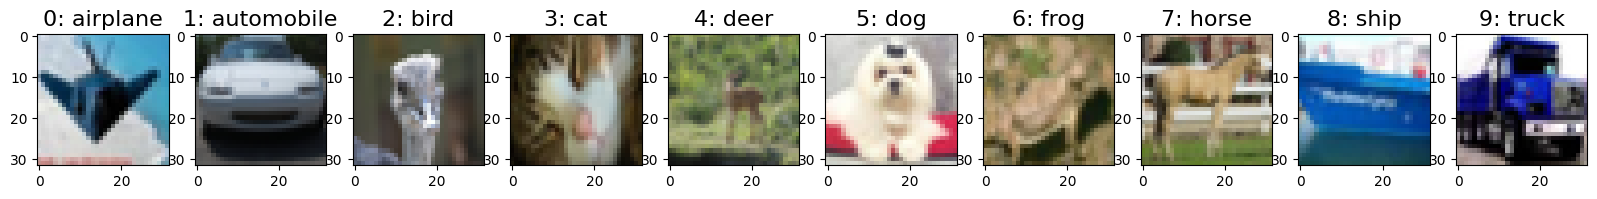

In [255]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
plt.savefig("Figure_8_cifar.pdf")
#from google.colab import files
#files.download('Figure_8_cifar.pdf') 


To simualte a novel class, you will delete all images of the class "horse" from the traning dataset. Note that you do this only in the trainset, the test dataset stays the same. In the train dataset you will now have 9 classes with 5'000 images of every class, in total 45'000 images. This will be your traning dataset for the three models.   

In [256]:
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print(y_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)
(45000, 9)


Now you split the new training dataset without the horses randomly into a train and validationset. You use a 60:40 ratio for the split, so you have 27'000 train images with 9 classes and 18'000 validation images with 9 classes. The test dataset has 10'000 images and 10 classes. Note that we have a novel (unknown) class "horse" in the testset.

In [257]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

#Before training the NNs with the data, we normalize the data to be in the range between -1 and 1. 
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

x_test.min(), x_test.max()

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


(-1.0, 1.0)

In [258]:
#Experiment to bring it back to 0 and 255
x_test_exp=((x_test/2)+0.5)*255
x_test_exp.min(), x_test_exp.max()

# Experiment with experument to bring it to 0 and 1.
def revertscale_fn(img):
    img = img.astype(np.float32) / 2
    img = (img + 0.5) * 255
    return img
# gen = ImageDataGenerator(
#     preprocessing_function=revertscale_fn,
#     rescale = 1./255,
# )

## Non-Bayesian CNN

In this section we use a CNN with two convolutional blocks, followed by maxpooling layers. You use 8 kernels with the size 3x3 in the first convolutional block and in the second block you use 16 kernels with the size 3x3. The maxpoolingsize is 2x2 pixels. After the feature extraction you use a flatten layer and do the classification with 3 fully connected layers. Because the training takes a lot of time, you will load an already trained CNN with the learning curve.

In [259]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                 

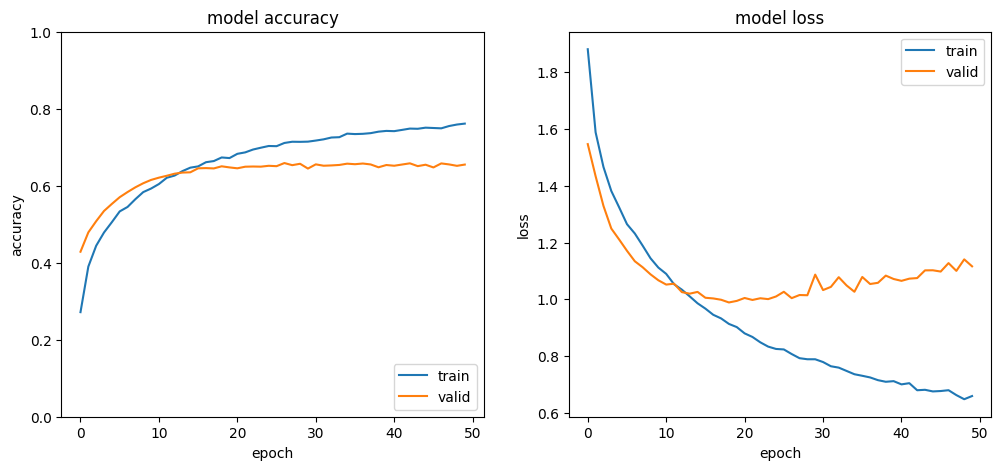

In [260]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_baseline_cifar10.csv", "history_baseline_cifar10.csv")
history=np.loadtxt("history_baseline_cifar10.csv",delimiter=",")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [261]:
# load trained weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

I didn't know if the model was trained using EarlyStop or Val_Loss, I just see that the previous model was trained on accuracy so I want to train the model and double check that it was stopped around epoch 20 and note epoch 50 where the validation loss increased.



In [262]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)
# history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, verbose='0', callbacks = [callback], validation_data=(x_val, y_val))
# history = history.history

In [263]:
# First of all call dict. items() to return a group of the key-value pairs in the dictionary.
# Then use list(obj) with this group as an object to convert it to a list.
# At last, call numpy. array(data) with this list as data to convert it to an array.
 

In [264]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])
# plt.ylim(0, 1)
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='lower right')
# plt.subplot(1,2,2)
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper right')
# plt.show()

Here you save the indices of the known and the unknown (horse) classes. You will use them later to evaluate the uncertainty measures.

In [265]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))

9000
1000


what is the given acuracy on the train and val set?

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


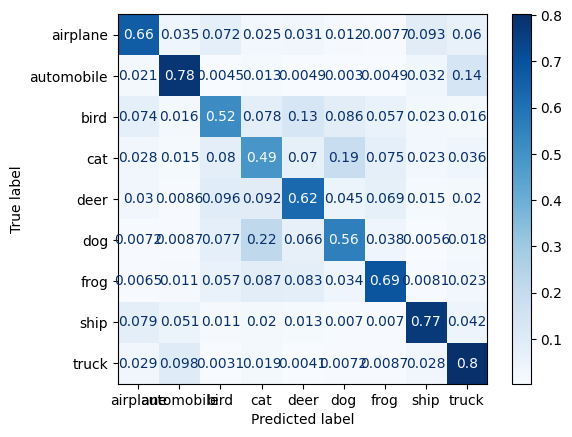

(0.6549444444444444, 0.6556666666666666)

In [266]:
pred=model.predict(x_val)  #array (18000, 9)
pred_max_p=np.max(pred,axis=1) #array of (18000,)

entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll_=-np.log(pred_max_p)
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels_no_horse[np.argmax(y_val[i])] for i in range(0,len(y_val))])
cm = confusion_matrix(true_labels, pred_labels, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_no_horse)

disp.plot(cmap=plt.cm.Blues)
plt.show()


val_acc_all=np.average(true_labels==pred_labels)
val_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
val_acc_all, val_acc_known


## Accuracy on the the known labels in the train set for all three models 
In this section you will calculate the accuracies and of all three models. For the non bayesian NN, you will predict every test image once and for the two bayesian NN, you will predict every image 50 times and then takes the mean of all predicted classes. 





#### Non-Bayesian prediction

Here you predict the labels for the non-bayesian CNN and calculate the uncertainty measures. You calculate the nll and the entropy, note that there is no total standart deviation in the non-bayesian model, because the same image will always get the same prediction. This is also the reason why we don't need to predict the same image for multiple times.

In [267]:
# This is how you get accuracy from the Baseline Vanilla CNN. These predictions only work for deterministic sources

# pred=model.predict(x_test)
# pred_max_p=np.max(pred,axis=1)
# entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
# nll_=-np.log(pred_max_p)
# pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
# true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])

# test_acc_all=np.average(true_labels==pred_labels)
# test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
# test_acc_all, test_acc_known

In [268]:
pred=model.predict(x_test)
pred_max_p=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll_=-np.log(pred_max_p)
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])
 

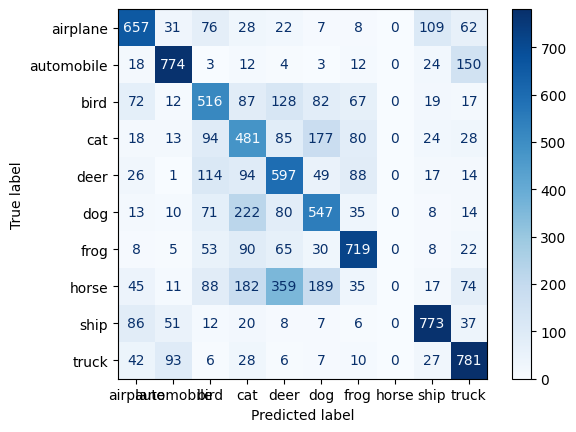

In [269]:
 
cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [270]:

test_acc_all=np.average(true_labels==pred_labels)
test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
test_acc_all, test_acc_known

(0.5845, 0.6494444444444445)

Confusion Matrix for Test-Data from Model

#### 🆕 Test Time Augmentation

Here I predict the labels for the traditional CNN with Test Time Augmentation and possibly calculate the uncertainty measures.  I predict the same image for 50 times and calculate the mean predicted probabilities, the nll, the entropy, and total standard deviations. 

Define the Test Time Image Generator

Keras has predefined choices of [augmentations defined here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) and explained visually well [here](https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) in a TowardsDataScience Medium Blog Post 

In [271]:
import neptune.new as neptune


In [272]:
run = neptune.init(
    project="rachel.ramirez2006/VanillaCNN-CIFAR10-TTA-Keras",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NWZjMGEyYy1mZGI3LTQ1NWMtOGUyZi0wODc2OWI2OGU3NzcifQ==",
)  # your credentials

https://app.neptune.ai/rachel.ramirez2006/VanillaCNN-CIFAR10-TTA-Keras/e/VAN-12
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [273]:
tta_steps = 50
bs = 64
# epochs = 15

There are the original tried test_datagen that have resulted in the highest accuracy scores:

        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [274]:
params = {'rotation_range': 10, 
          'shear_range': 20,
          'zoom_range' : 0.1,
          'horizontal_flip': True, 
          'width_shift_range' : 0.1,
          'height_shift_range' : 0.1 ,

          'featurewise_center': False,
          'samplewise_center': False,
          'featurewise_std_normalization': False,
          'samplewise_std_normalization' : False,

          'zca_whitening' : False,
          'width_shift_range'	: 0.1, 
          'height_shift_range'  : 0.1,

          'brightness_range' : (1.1,1.5),
          'channel_shift_range': 10,
          'fill_mode' : 'reflect',

            # 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            # 'nearest': aaaaaaaa|abcd|dddddddd
            # 'reflect': abcddcba|abcd|dcbaabcd
            # 'wrap': abcdabcd|abcd|abcdabcd
            # cval	Float or Int. Value used for points outside the boundaries when fill_mode = "constant".
        'vertical_flip': False}
run["parameters"] = params


In [275]:
test_datagen = ImageDataGenerator(
        #preprocessing_function=revertscale_fn,   #hoping this will increase the overall accuracy of TTA from 0.448 to something more similar to the vanilla CNN without TTA - IT DID NOT
        #rescale = 1./255,
        shear_range=params['shear_range'],
        zoom_range=params['zoom_range'],
        horizontal_flip=params['horizontal_flip'],
        rotation_range= params['rotation_range'],
        fill_mode=params['fill_mode'] ,
        width_shift_range = params['width_shift_range'], 
        height_shift_range = params['height_shift_range'],

       featurewise_center = params['featurewise_center'],
       samplewise_center  = params['samplewise_center'],
       featurewise_std_normalization = params['featurewise_std_normalization'],
       samplewise_std_normalization = params['samplewise_std_normalization'],

        zca_whitening = params['zca_whitening'],

        brightness_range = params['brightness_range'],
 
        channel_shift_range = params['channel_shift_range'],
        vertical_flip = params['vertical_flip']
        )

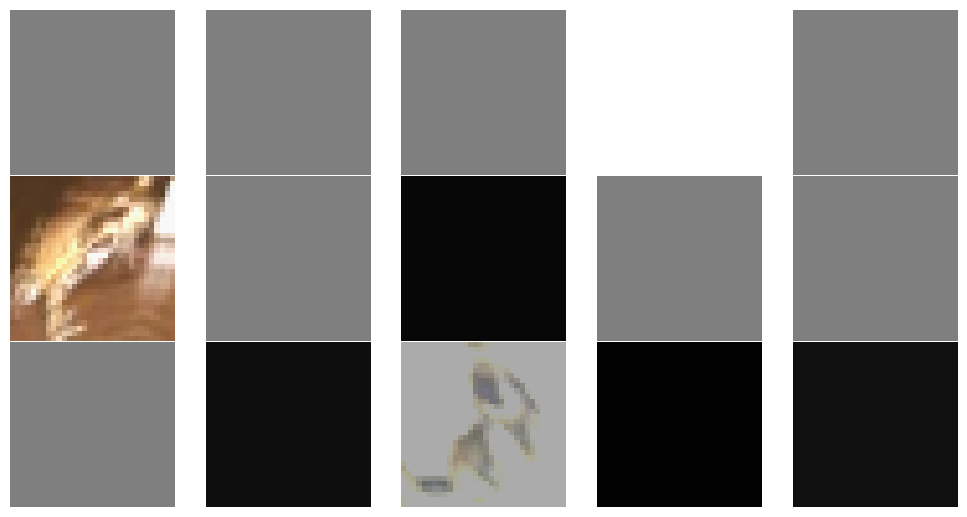

In [276]:
# # # My TTA was 0.09, which makes me think there is a disconnect between the types of format for x_train, x_val, or x_test being in the format specified here between -1 and 1 and the TTA notebook where it is simply between 0 and 1.
# # # So my first step is to try to display the pictures
display_datagen = ImageDataGenerator(
      preprocessing_function=revertscale_fn,   #yay that worked
      rescale = 1./255,
        shear_range=params['shear_range'],
        zoom_range=params['zoom_range'],
        horizontal_flip=params['horizontal_flip'],
        rotation_range= params['rotation_range'],
        fill_mode=params['fill_mode'] ,
        width_shift_range = params['width_shift_range'], 
        height_shift_range = params['height_shift_range'],

       featurewise_center = params['featurewise_center'],
       samplewise_center  = params['samplewise_center'],
       featurewise_std_normalization = params['featurewise_std_normalization'],
       samplewise_std_normalization = params['samplewise_std_normalization'],

        zca_whitening = params['zca_whitening'],

        brightness_range = params['brightness_range'],
 
        channel_shift_range = params['channel_shift_range'],
        vertical_flip = params['vertical_flip'],


)

display_datagen.fit(x_train)

plt.figure(figsize=(10,5))

for X_batch, y_batch in display_datagen.flow(x_train, y_train, batch_size=15):
    for i in range(0, 15):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()
    break

In [277]:
# # My TTA was 0.09, which makes me think there is a disconnect between the types of format for x_train, x_val, or x_test being in the format specified here between -1 and 1 and the TTA notebook where it is simply between 0 and 1.
# # So my first step is to try to display the pictures

test_datagen.fit(x_train)

# plt.figure(figsize=(10,5))

# for X_batch, y_batch in test_datagen.flow(x_train, y_train, batch_size=15):
#     for i in range(0, 15):
#         plt.subplot(3, 5, i+1)
#         plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
#         plt.axis('off')
#     plt.tight_layout(pad=0.1)
#     plt.show()
#     break

In [ ]:
predictions_tta = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_datagen.flow(x_test, batch_size=bs, shuffle=False), steps = len(x_test)/bs)   #Changed X_val to X_test 
    predictions_tta.append(preds)
 

<ipython-input-278-3dcd13f70952>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(tta_steps)):


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# predictions_tta[0][0]   #the first guess of #tta_steps for the 0th image, 1st prob guess is "3" followed by "5"
# predictions_tta[9][0]   #the 9th   guess of #tta_steps for the 0th image, 1st largest prob is "3" followed by "5"
# y_test[0]               #the actual label of the 0th test image is "3" so it would have got this correct.

In [ ]:
final_pred = np.mean(predictions_tta, axis=0)

# final_pred[0] #This is the average guess for image 0, "3" followed by "5"

np.argmax(final_pred[0])

In [ ]:
# Size of things
#final_pred         # An array of 10000x9 10000 images with 9 classes of probabilities
#predictions_tta    # A list of 11 of  10000 images with 9 classes of probabilities

In [ ]:
# final_pred

pred_tta=np.zeros((len(x_test),9))
pred_max_p_tta=np.zeros((len(x_test)))
pred_std_tta=np.zeros((len(x_test)))
entropy_tta = np.zeros((len(x_test)))


for i in tqdm(range(0,len(x_test))):
  #multi_img=np.tile(x_test[i],(50,1,1,1))
  #preds=model_mc_pred([multi_img,1])
  pred_tta[i]= final_pred[i]
  pred_max_p_tta[i]=np.argmax(final_pred[i]) #mean over n runs of every proba class
  pred_std_tta[i]= np.sqrt(np.sum(np.var(final_pred[i])))
  entropy_tta[i] = -np.sum( pred_tta[i] * np.log2(pred_tta[i] + 1E-14)) #Numerical Stability
pred_labels_tta=np.array([labels_no_horse[np.argmax(pred_tta[i])] for i in range(0,len(pred_tta))])
pred_tta_mean_max_p=np.array([pred_tta[i][np.argmax(pred_tta[i])] for i in range(0,len(pred_tta))])
nll_tta=-np.log(pred_tta_mean_max_p)




# Non-Bayesian copy/paste with final_pred, didn't work... 
# pred_max_p=np.max(final_pred,axis=1)
# entropy_tta=np.array([-np.sum( final_pred[i] * np.log2(final_pred[i] + 1E-14)) for i in range(0,len(final_pred))])
# nll_tta=-np.log(pred_max_p)
# pred_labels_tta=np.array([labels_no_horse[np.argmax(final_pred[i])] for i in range(0,len(final_pred))])
# true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])


test_acc_all_tta=np.average(true_labels==pred_labels_tta)
test_acc_known_tta=np.average(true_labels[known_idx]==pred_labels_tta[known_idx])
test_acc_all_tta, test_acc_known_tta

Attempting Confusion Matrix

In [ ]:
 
cm_tta = confusion_matrix(true_labels, pred_labels_tta)
disp_tta = ConfusionMatrixDisplay(confusion_matrix=cm_tta, display_labels=labels)
disp_tta.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
run["test_acc_all_tta"] = test_acc_all_tta
run["test_acc_known_tta"] = test_acc_known_tta
run["test_acc_all"] = test_acc_all
run["test_acc_known"] = test_acc_known
run["pred_labels_tta"] = pred_labels_tta
run["true_labels"] = true_labels
run["nll_tta"] = nll_tta
run["entropy_tta"] = entropy_tta
run["pred_max_p"] = pred_max_p

run["val_cm"] = cm
run["test_cm"] = cm_tta

run.stop()

### See the impact of TTA on a single image

In [ ]:
image_ix = 1
test_image = x_val[image_ix]
plt.imshow(test_image)
plt.title(f'real label: {np.argmax(y_val[image_ix])}')
plt.axis('off');

In [ ]:
plt.figure(figsize=(20,14))
predictions_tta_idx = []

for i in range(5):
    im = test_datagen.flow(test_image.reshape(1,32,32,3), batch_size=1, shuffle=False)
    im = next(im)
    pred = model.predict(im.reshape(1,32,32,3))
    predictions_tta_idx.append(pred)
    plt.subplot(1, 5, i+1)
    plt.title(f'pred label: {np.argmax(pred)}')
    plt.imshow(im.reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [ ]:
final_pred_idx = np.mean(predictions_tta_idx, axis=0)
print(f'final pred: {np.argmax(final_pred_idx)}')